In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.optimize import minimize
from docplex.mp.model import Model
from math import floor, ceil
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# functions: 
def unconstrained_unbounded(mdl, coef, params):
    '''
    Function help: 
    Input: 
    mdl: {cplex model} this is a cplex model with constraints 
    coef: {list} these are the optimization variables. 
    params: {dict} This contains the dataset.
    
    
    '''
    netvind_MVA = params['netvind_MVA']
    wind_pp = params['wind_pp']
    solar_pp = params['solar_pp']
    simbench_load_profiles = params['simbench_load_profiles']
    num_profiles_from_simbench = simbench_load_profiles.shape[1]
    num_timestamps_NV = len(netvind_MVA)
    mdl.minimize(mdl.sumsq(
        (netvind_MVA[i] + coef[0] * solar_pp[i, 1] +  coef[1] * wind_pp[i] \
         - mdl.sum( coef[j + 2] * simbench_load_profiles[i, j] for j in
                   range(num_profiles_from_simbench))) \
        for i in range(num_timestamps_NV))/num_timestamps_NV)
    sol = mdl.solve(log_output=False)

    return sol

'''
Variables: 
1. Total solar installation capacity
2. Total wind installation capacity 
3. Maximum MVA per simbench profile 
'''
# Variables:

# capacity bounds

def bounded_objective(mdl, coef, num_of_install, params):
    netvind_MVA = params['netvind_MVA']
    wind_pp = params['wind_pp']
    solar_pp = params['solar_pp']
    simbench_load_profiles = params['simbench_load_profiles']
    num_profiles_from_simbench = simbench_load_profiles.shape[1]
    num_timestamps_NV = len(netvind_MVA)
    mdl.minimize(mdl.sumsq((netvind_MVA[i]+num_of_install[0]*coef[0]*solar_pp[i,1]+num_of_install[1]*coef[1]*wind_pp[i]\
                          -mdl.sum(num_of_install[j+2]*coef[j+2]*simbench_load_profiles[i,j] for j in range(num_profiles_from_simbench))) \
                        for i in range(num_timestamps_NV))/num_timestamps_NV)
    sol = mdl.solve(log_output=False)
    #print(f'Objective {sol.objective_value}')
    #sol.display()
    return sol.objective_value

def bounded(mdl, coef, num_of_install, params):
    netvind_MVA = params['netvind_MVA']
    wind_pp = params['wind_pp']
    solar_pp = params['solar_pp']
    simbench_load_profiles = params['simbench_load_profiles']
    num_profiles_from_simbench = simbench_load_profiles.shape[1]
    num_timestamps_NV = len(netvind_MVA)
    mdl.minimize(mdl.sumsq((netvind_MVA[i]+num_of_install[0]*coef[0]*solar_pp[i,1]+num_of_install[1]*coef[1]*wind_pp[i]\
                          -mdl.sum(num_of_install[j+2]*coef[j+2]*simbench_load_profiles[i,j] for j in range(num_profiles_from_simbench))) \
                        for i in range(num_timestamps_NV))/num_timestamps_NV)
    sol = mdl.solve(log_output=True)
    print(f'Objective {sol.objective_value}')
    #sol.display()
    return sol

In [3]:
# is not used anymore
def get_correlations(minute, avg=False):
    correlations= np.zeros([10,27])
    months = [12,1,2,3,4,5,6,7,8,9]
    k  =0
    for j in months:
        sim_january = [a for a in range(len(simbench_timestamps)) if simbench_timestamps[a].month==j and simbench_timestamps[a].minute==minute]
        net_january = [a for a in range(len(netvind_pu)) if netvind_pu[a,0].month==j]
        if len(sim_january)>len(net_january):
            sim_january = sim_january[:len(net_january)]
        elif len(sim_january)<len(net_january): 
            net_january = net_january[:len(sim_january)]
        dum_simbench = np.zeros([len(net_january), 27])
        for i in range(1,27):
            if avg == True:
                dum_simbench = [np.mean(simbench_load_profiles_MVA_pu[alpha:alpha+4, i]) for alpha in sim_january]
            else: 
                dum_simbench = simbench_load_profiles_MVA_pu[sim_january,i]
            correlations[k, i-1] = scipy.stats.pearsonr(netvind_MVA_pu[net_january],\
                                                     dum_simbench)[0]
        k = k+1
    return correlations


In [4]:
#from run_profileAllocation import unconstrained_unbounded, bounded_objective, bounded

'''
This file is used for the following purposes: 
    1. parameters
    2. loading data. 
'''

params = {'node_60kV' : 'GLO',
          'data_loc': '..\\data\\',
          'dinemo_loc': '..\\data\\DiNeMo Data\\',
          'corres_loc':'..\\data\\corres_data\\',
          'netvind_loc':'..\\data\\netvind_loads_and_network\\'}

nameVsProfile = np.array(np.genfromtxt('..\\data\\name_to_profile.txt', delimiter=',', dtype=['S16, f8']).tolist())
for i in nameVsProfile:
    if i[0][0].decode() == params['node_60kV']:
        profile_no = i[0][1].decode()[:2]
del nameVsProfile
'''
Specify file names with locations
'''
# consumer_file= 'Ørum 001\\CConsumer.shp' We shall use this later
solar_filename = params['corres_loc']+'SOLAR_POW_' + params["node_60kV"]+'.csv'
wind_filename = params["corres_loc"]+'WPP_LEM_POW'+'.csv'
netvind_filename = params["netvind_loc"] + profile_no +'.csv'
simbench_filename = params['data_loc'] + "simbench_loads_profiles_pu.csv"
dinemo_filename = params['dinemo_loc'] + params['node_60kV'] + '\\'+ 'CConsumer.csv'

In [5]:
#################### load netvind profile
netvind_pu = np.array(np.genfromtxt(netvind_filename, delimiter=',', dtype=['datetime64[s]', 'f8', 'f8', 'f8'],\
                                    skip_header=1, encoding='ascii').tolist())
netvind_MVA_pu = (netvind_pu[:,1]**2 + netvind_pu[:,2]**2)**0.5

num_timestamps_NV = len(netvind_MVA_pu)

In [6]:
netvind_timestamps = netvind_pu[:,0]


In [7]:
#################### Load simbench reference load profiles in pu
num_profiles_from_simbench = 27
dtype_pro = ['f8']*num_profiles_from_simbench*2   # There are 25 different load profiles available from Simbench.
dtype_list = ['S16']
dtype_list = dtype_list.append(dtype_pro)
simbench_all_profiles_STR = np.array(np.genfromtxt(simbench_filename, delimiter=';',dtype=dtype_list, encoding=None).tolist())

len_timestamps_from_simbench = simbench_all_profiles_STR.shape[0] - 1
simbench_all_load_profiles = np.zeros( [len_timestamps_from_simbench, num_profiles_from_simbench * 2])  # multiply 2 in the number of profiles to account for reactive power.
simbench_timestamps = []



In [8]:
sim_names = simbench_all_profiles_STR[0][:][1:]

In [9]:
for i in range(len_timestamps_from_simbench):
    simbench_timestamps.append(datetime.strptime(simbench_all_profiles_STR[i + 1][0], '%d.%m.%Y %H:%M'))
    for j in range(num_profiles_from_simbench * 2):
        simbench_all_load_profiles[i, j] = float(simbench_all_profiles_STR[i + 1][j + 1])

simbench_load_profiles_MVA_pu = np.zeros([len_timestamps_from_simbench,num_profiles_from_simbench])
for i in range(num_profiles_from_simbench):
    #if i%2 == 0:
    temp = np.sqrt(simbench_all_load_profiles[:,i]**2 + simbench_all_load_profiles[:,i+1]**2)
    simbench_load_profiles_MVA_pu[:, i] = temp # MVA in p.u

del len_timestamps_from_simbench, simbench_all_load_profiles, simbench_all_profiles_STR, temp, i, j, dtype_list, dtype_pro

simbench_0_index = [i for i in range(len(simbench_timestamps)) if simbench_timestamps[i].minute == 0]
simbench_load_profiles_index0_MVA_pu = simbench_load_profiles_MVA_pu[simbench_0_index[:num_timestamps_NV], :]

In [10]:
# Solar and wind profiles: 
dtype_lst = ['datetime64[s]']
temp = ['f8']
dtype_lst.extend(temp)
solar_pp = np.array(np.genfromtxt(solar_filename, delimiter=',', dtype=dtype_lst, skip_header=1, encoding='ascii').tolist())

# start solar time stamps from 8th of December 2014 at 10 am.  
solar_pp_pu = solar_pp[(7*24)+10: num_timestamps_NV+(7*24)+10]
# get wind profile
wind_pp = np.array(np.genfromtxt(wind_filename, delimiter=',', dtype='f8', skip_header=1,  usecols=[34]).tolist())
# start wind time stamps from 8th of December 2014 at 10 am.  
wind_pp = wind_pp[(7*24)+10: num_timestamps_NV+(7*24)+10]
del dtype_lst, temp

OSError: ..\data\corres_data\SOLAR_POW_GLO.csv not found.

# Preprocessing Simbench data. 

    1. Simbench data is given at 15 minute intervals, whereas, netvind at 1 hour intervals. So we calculate 1 hour averages for simbench data
    2. simbench_timestamps_new = timestamps when minute == 0

In [ ]:
# Average over an hour for all simbench timestamps 
num_simbench = len(simbench_timestamps)
# separating hour timestamps
hour_indices = [a for a in range(num_simbench) if simbench_timestamps[a].minute==0] 
simbench_timestamps_new  = [simbench_timestamps[hour] for hour in hour_indices]
simbench_1_hour_avg = np.zeros([int(num_simbench/4), simbench_load_profiles_MVA_pu.shape[1]])
for j in range(len(hour_indices)):
    for i in range(27):               # Average                     Over 4 timestamps starting from minute == 0                                     
        simbench_1_hour_avg[j,i] = np.mean(simbench_load_profiles_MVA_pu[hour_indices[j]:hour_indices[j]+4, i])

In [12]:
simbench_timestamps_new = np.array(simbench_timestamps_new) # converting simbench timestamps from list to numpy array

    3. Equating simbench timestamps to netvind with respect to month, date, hour. This also calculates if any data is missing 

In [13]:
month_nos = [12,1,2,3,4,5,6,7,8,9]
net_sim_indices = []
missing_date = []
for net_date in netvind_timestamps:
    k = 0
    flag_continue = True
    while flag_continue:
        if simbench_timestamps_new[k].month==net_date.month and \
            simbench_timestamps_new[k].day==net_date.day and \
            simbench_timestamps_new[k].hour==net_date.hour:
            net_sim_indices.append(k)
            flag_continue = False
        else: 
            k = k+1
            if k == len(simbench_timestamps_new):
                flag_continue = False
                print(f"missing {net_date} ")
                missing_date.append(net_date)
                

missing 2015-03-27 02:00:00 


In [14]:
print(f"No of missing dates: {len(missing_date)}")

No of missing dates: 1


In [15]:
# find out the indices of all the missing dates. 
k = 0
miss_date_index = []
for miss_date in missing_date:
    flag_continue = True
    while flag_continue:
        if netvind_timestamps[k].month== miss_date.month and \
           netvind_timestamps[k].day== miss_date.day and\
           netvind_timestamps[k].hour== miss_date.hour:
            
            miss_date_index.append(k) # missed date + hour index
            
            flag_continue=False
        else: 
            k = k+1
            

In [16]:
simbench_timestamps_old = simbench_timestamps_new # store all the simbench timestamps to new location

In [17]:
# rearrange and select indices for month, date, hour present both in netvind timestampos and simbench timestamps
simbench_timestamps_new = simbench_timestamps_new[net_sim_indices] 

# Rearrange and select the load profiles for those timestamps. 
simbench_all = simbench_1_hour_avg[net_sim_indices] 

# Replace missing date with back fill. 
for i in range(len(miss_date_index)):
    simbench_all = np.insert(simbench_all, miss_date_index[i], simbench_all[miss_date_index[i], :], axis=0)

In [18]:
# Reinsert missing date in timestamps- 
simbench_timestamps_new = np.insert(simbench_timestamps_new,  miss_date_index[0],missing_date[0], axis=0)

### AT this point preprocessing is done

In [19]:
simbench_df  ={}
simbench_df['Timestamps'] = simbench_timestamps_new
for i in range(27):
    simbench_df[sim_names[i]]= simbench_all[:,i]

In [20]:
simbench_df = pd.DataFrame(simbench_df)
simbench_df.set_index('Timestamps', inplace=True)

In [21]:
netvind_df = {'Timestamps': netvind_timestamps, 'profile': netvind_MVA_pu}
netvind_df = pd.DataFrame(netvind_df)
netvind_df.set_index('Timestamps', inplace=True)

In [22]:
def correlations_new(netvind_df,simbench_df):
    correlations= np.zeros([10,27])
    months = [12, 1,2,3,4,5,6,7,8,9]
    month_position = np.array([netvind_df.index[a].month for a in range(len(netvind_df))])
    for i in range(10):
        indices = month_position == months[i]
        for k in range(27):
            correlations[i, k] = scipy.stats.pearsonr(netvind_df.iloc[indices,0],\
                                                     simbench_df.iloc[indices,k])[0]
    return correlations

In [23]:
correlations = correlations_new(netvind_df,simbench_df)

In [24]:
sim_names =   [sim_names[i][0:2] for i in np.arange(0,len(sim_names),2)]

In [25]:
sim_names

['H0',
 'H0',
 'H0',
 'H0',
 'H0',
 'L1',
 'L2',
 'L0',
 'G0',
 'G1',
 'G1',
 'G2',
 'G3',
 'G4',
 'G4',
 'G5',
 'G6',
 'L2',
 'G0',
 'G1',
 'G3',
 'G4',
 'H0',
 'G3',
 'G4',
 'BL',
 'BW']

In [26]:
sim_classification = [sim_names[i][0:1] for i in np.arange(0,len(sim_names),1)]

In [27]:
sim_classification = np.array(sim_classification)
sim_classification

array(['H', 'H', 'H', 'H', 'H', 'L', 'L', 'L', 'G', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'L', 'G', 'G', 'G', 'G', 'H', 'G', 'G', 'B',
       'B'], dtype='<U1')

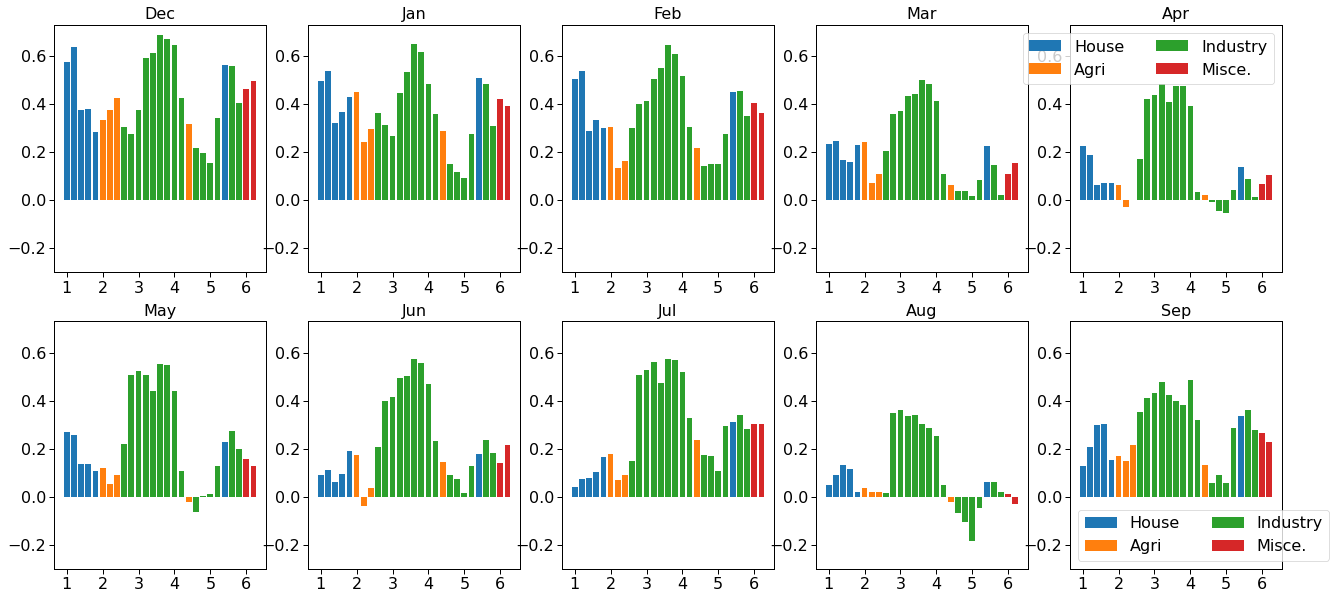

In [28]:
sns.set_context('paper')
fig, ax = plt.subplots(2,5, figsize=(22,10))
k = 0
#fig.suptitle(f'ORU Minute')
titles = ['Dec', 'Jan','Feb', 'Mar', 'Apr', 'May','Jun', 'Jul','Aug','Sep']
x_tick = np.arange(0,27,1)
for i in range(2):
    for j in range(5):
        idx = sim_classification == 'H'
        ax[i,j].bar(x_tick[idx],correlations[k,idx], label='House')
        idx = sim_classification == 'L'
        ax[i,j].bar(x_tick[idx],correlations[k,idx], label='Agri')
        idx = sim_classification == 'G'
        ax[i,j].bar(x_tick[idx],correlations[k,idx], label='Industry')
        idx = sim_classification == 'B'
        ax[i,j].bar(x_tick[idx],correlations[k,idx], label='Misce.')
        #ax[i,j].axhline(y= 0.5)
        ax[i,j].set_title(titles[k], fontsize=16)
        ax[i,j].set_ylim(-0.3,0.73)
        
        ax[i,j].set_xticklabels(range(27),fontsize=16)
        ax[i,j].tick_params(axis='y',labelsize=16)
        k = k+1
    ax[i,j].legend(loc=0, ncol=2,fontsize=16)
        #plt.xticks(range(0,27),sim_names, rotation=90)
#plt.tight_layout()
plt.savefig('.\plots\GLO_correlations.png')
plt.show()

In [29]:
# The timeseries dictionary is made to be passed as an argument in the optimization function
timeseries = {'netvind_MVA':netvind_MVA_pu ,\
              'wind_pp':wind_pp, \
              'solar_pp':solar_pp_pu, \
              'simbench_load_profiles':simbench_all } # simbench_all is the averaged and rearranged timeseries. 
    


    

In [30]:
# CPLEX MODEL: 
mdl1 = Model(name='Capacity_estimation_unbounded')

# The bounds are very large
lower_bound_dummy = np.zeros(num_profiles_from_simbench+2)
upper_bound_dummy = np.ones(num_profiles_from_simbench+2)*100

# adding variables: only the installed capacities for all the profiles in MW
coef = mdl1.continuous_var_list(num_profiles_from_simbench + 2, lower_bound_dummy, upper_bound_dummy, name='coef')


In [31]:
# Calling the function. 
solution1 = unconstrained_unbounded(mdl1, coef, timeseries)
print(f'RMSE Error: {np.sqrt(solution1.objective_value)} MVA')
sol1 = [solution1.get_value(i) for i in coef]


RMSE Error: 0.23456360525478634 MVA


In [32]:
gen_at10kV = np.hstack((np.expand_dims(timeseries['solar_pp'][:,1], axis=1), np.expand_dims(timeseries['wind_pp'], axis=1)))
load_at10kV = timeseries['simbench_load_profiles']
netvind_only_load_1 =timeseries['netvind_MVA']
solution_1_at10kV = load_at10kV@sol1[2:]- gen_at10kV@sol1[0:2]
corr_sol1 = scipy.stats.pearsonr(netvind_only_load_1, solution_1_at10kV)
print(f'Correlation between the profiles {corr_sol1}')

Correlation between the profiles (0.6788616597588846, 0.0)


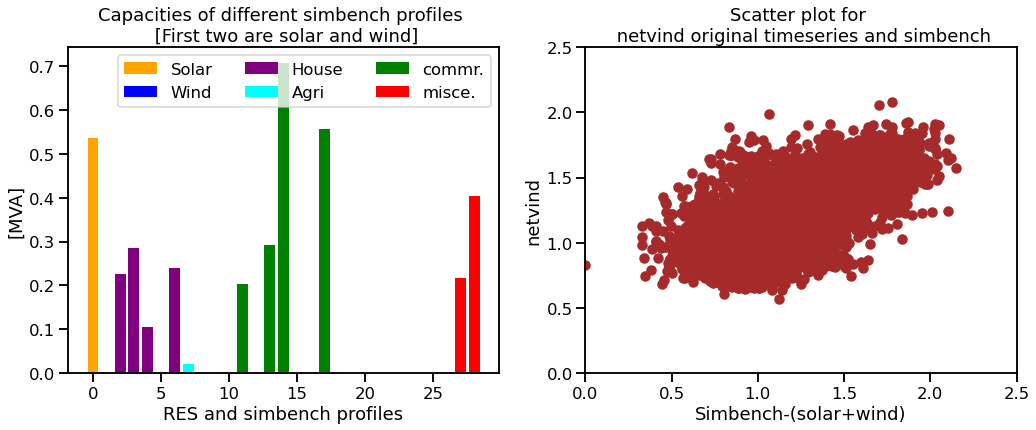

In [296]:
sns.set_context('talk')
fig, ax = plt.subplots(1,2,figsize=(17,6))
#fig.suptitle(f'For Month = {month}')

x = np.arange(2,29)

ax[0].bar(0, sol1[0], color='orange', label='Solar')
ax[0].bar(1, sol1[1], color='blue', label='Wind')
sol_sim = np.array(sol1[2:])
idx = sim_classification == 'H'
ax[0].bar(x[idx], sol_sim[idx], label='House', color='purple')
idx = sim_classification == 'L'
ax[0].bar(x[idx], sol_sim[idx], label='Agri',color='aqua')
idx = sim_classification == 'G'
ax[0].bar(x[idx], sol_sim[idx], label = 'commr.', color='green')
idx = sim_classification == 'B'
ax[0].bar(x[idx], sol_sim[idx], label='misce.', color='red')
ax[0].legend(ncol=3)
ax[0].set_title('Capacities of different simbench profiles \n [First two are solar and wind]')
ax[0].set_xlabel('RES and simbench profiles')
ax[0].set_ylabel('[MVA]')

ax[1].set_title('Scatter plot for \n netvind original timeseries and simbench')
ax[1].scatter(netvind_only_load_1,solution_1_at10kV, color='brown')
ax[1].set_xlabel('Simbench-(solar+wind)')
ax[1].set_ylabel('netvind')
ax[1].set_xlim(0,2.5)
ax[1].set_ylim(0,2.5)
plt.savefig('.\plots\capacitiesForGLO.png')
plt.show()




#plt.hist(netvind_only_load_1-solution_1_at10kV)
#plt.title('Histogram of Errors')

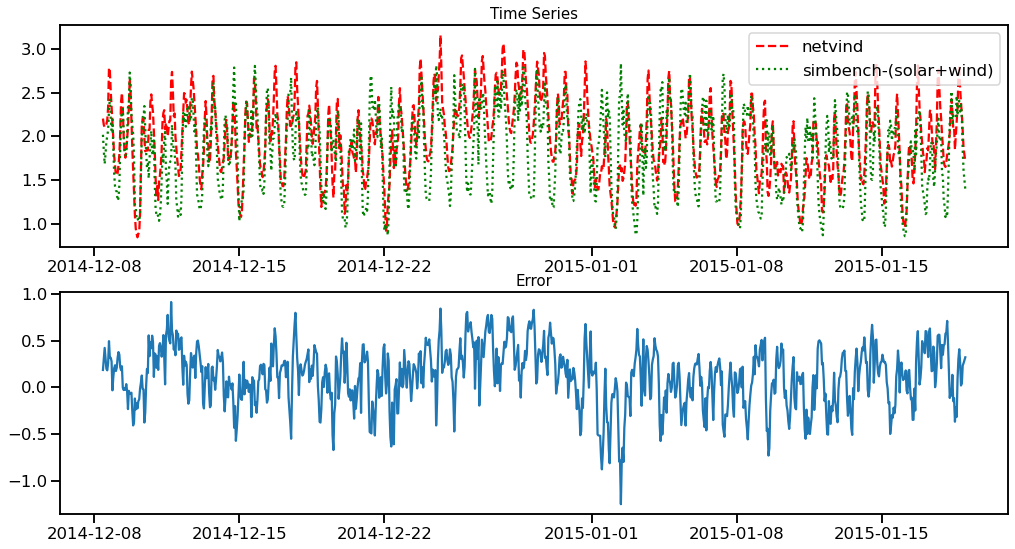

In [223]:
fig, ax = plt.subplots(2,1,figsize=(17,9))
ax[0].set_title('Time Series', fontsize=15)
ax[0].plot(netvind_timestamps[0:1000],netvind_only_load_1[0:1000],'--r', label='netvind')
ax[0].plot(netvind_timestamps[0:1000],solution_1_at10kV[0:1000],':g', label='simbench-(solar+wind)')
ax[0].legend()
ax[1].set_title('Error', fontsize=15)
ax[1].plot(netvind_timestamps[0:1000],netvind_only_load_1[0:1000]-solution_1_at10kV[0:1000])
plt.savefig('.\plots\Timeseries_first1000.png')
plt.show()

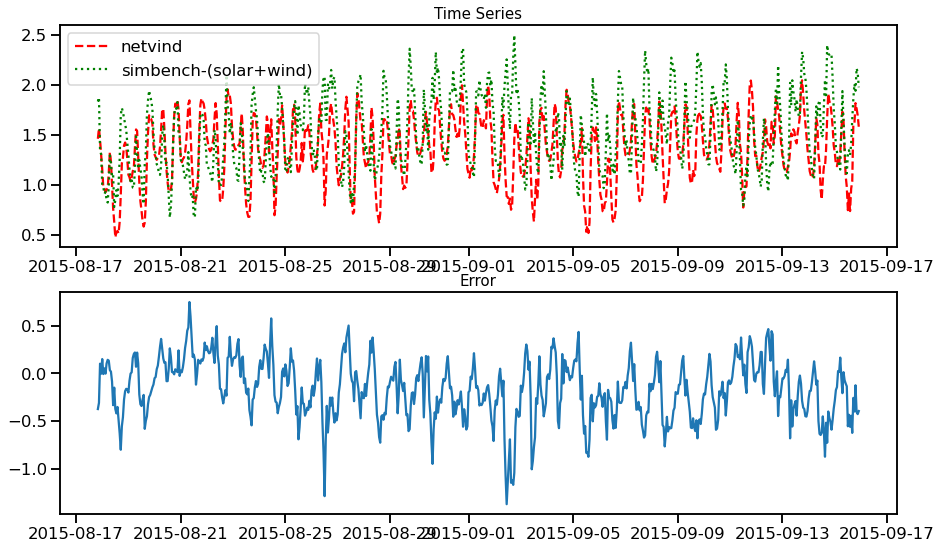

In [248]:
fig, ax = plt.subplots(2,1,figsize=(15,9))
ax[0].set_title('Time Series', fontsize=15)
ax[0].plot(netvind_timestamps[-700:-1],netvind_only_load_1[-700:-1],'--r',label='netvind')
ax[0].plot(netvind_timestamps[-700:-1],solution_1_at10kV[-700:-1],':g',label='simbench-(solar+wind)')
ax[0].legend()
ax[1].set_title('Error', fontsize=15)
ax[1].plot(netvind_timestamps[-700:-1],netvind_only_load_1[-700:-1]-solution_1_at10kV[-700:-1])
plt.savefig('.\plots\Timeseries_last1000.png')
plt.show()

In [297]:
residuals = netvind_only_load_1-solution_1_at10kV

# Residual analysis

In [298]:
from statsmodels.graphics.tsaplots import plot_acf      # import ACF plot
from statsmodels.graphics.tsaplots import plot_pacf     # import PACF plot

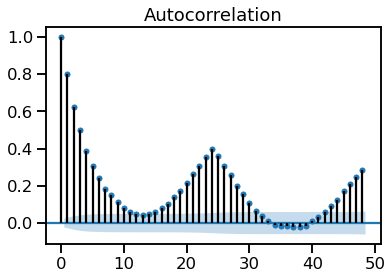

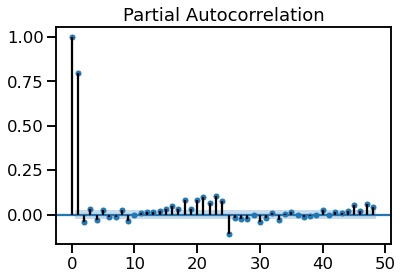

In [300]:
fig, ax = plt.subplots()
plot_acf(residuals, lags=48,ax=ax, zorder=0)
plt.savefig('.\plots\ACF001.png')
fig, ax = plt.subplots()
plot_pacf(residuals, lags=48,ax=ax, zorder=0)
plt.savefig('.\plots\PACF001.png')
plt.show()

 The auto correlation plot shows significant values till approx. 24 points, then the autocorrelation increases. This shows that the residuals are not white noise. There is an underlying load profile which is not accounted for.

In [103]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [301]:
query = netvind_only_load_1
template = solution_1_at10kV

In [302]:
alignment = dtw(query, template, keep_internals=True, )

In [303]:
alignment.plot(type="threeway", figsize=(15,15))

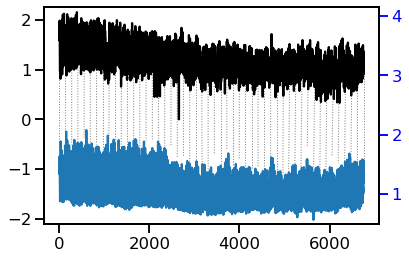

In [304]:
dtw(query, template, keep_internals=True,
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

In [305]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(query[:500], label='netvind')
ax.plot(alignment.index1[:700],template[alignment.index2][:700], label='DTW profile')
ax.plot(template[:500], label='Simbench', ls=':')
plt.legend()
plt.savefig('.\plots\DTW_200points.png')

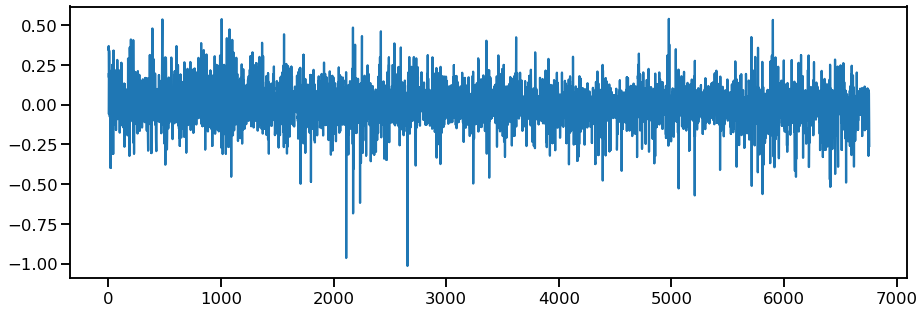

In [306]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(alignment.index1,query[alignment.index1]-template[alignment.index2])
#ax[1].plot(query-template)

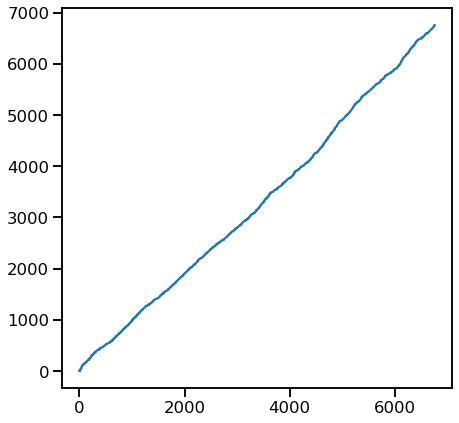

In [314]:
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(alignment.index1, alignment.index2)


In [308]:
error_before = np.sqrt(np.mean((query-template)**2))
error = np.sqrt(np.mean((query[alignment.index1]-template[alignment.index2])**2))

In [309]:
print(f"Error before DTW: {error_before}")
print(f"Error after DTW: {error}")

Error before DTW: 0.23456360525478664
Error after DTW: 0.1020608248969094


# Residual Analysis

In [310]:
residuals = query[alignment.index1]-template[alignment.index2]

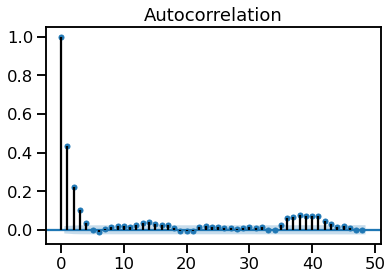

In [311]:
fig, ax = plt.subplots()
plot_acf(residuals, lags=48,ax=ax, zorder=0)
plt.savefig('.\plots\ACF002.png')
fig, ax = plt.subplots()
plot_pacf(residuals, lags=48,ax=ax, zorder=0)
plt.savefig('.\plots\PACF002.png')
plt.show()

In [243]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(residuals)